# Laboratorium 4 - Recurrent Neural Network cz. II

https://www.analyticsvidhya.com/blog/2021/03/introduction-to-long-short-term-memory-lstm/
https://www.geeksforgeeks.org/deep-learning-introduction-to-long-short-term-memory/
https://www.geeksforgeeks.org/gated-recurrent-unit-networks/?ref=lbp
https://towardsdatascience.com/building-rnn-lstm-and-gru-for-time-series-using-pytorch-a46e5b094e7b
https://medium.com/@mfouzan144/understanding-lstm-gru-and-rnn-architectures-e0b3a0c1d741


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

In [ ]:
# Wczytanie danych z pliku CSV
df = pd.read_csv('/content/airline-passengers.csv')

# Przetworzenie danych do postaci tablicy numpy typu float32
timeseries = df[["Passengers"]].values.astype('float32')

# Podział danych na zbiory treningowy i testowy
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

# Funkcja pomocnicza do tworzenia zestawów danych
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [ ]:
# Określenie okresu opóźnienia (lookback) i utworzenie zestawów danych treningowych i testowych
lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

<ipython-input-3-91467f096fe7>:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  return torch.tensor(X), torch.tensor(y)


In [ ]:
# Definicja klasy modelu LSTM
class LSTM_net(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [ ]:
# Inicjalizacja modelu, optymalizatora i funkcji straty
model = LSTM_net()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()

# Tworzenie DataLoader dla ładowania danych treningowych w paczkach
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)


Epoch 0: train RMSE 225.5350, test RMSE 424.7351
Epoch 100: train RMSE 175.9428, test RMSE 372.6976
Epoch 200: train RMSE 138.8075, test RMSE 331.9318
Epoch 300: train RMSE 108.9537, test RMSE 296.1124
Epoch 400: train RMSE 85.8736, test RMSE 263.3377
Epoch 500: train RMSE 64.7105, test RMSE 230.1732
Epoch 600: train RMSE 50.4431, test RMSE 202.1178
Epoch 700: train RMSE 40.4832, test RMSE 177.8707
Epoch 800: train RMSE 33.8512, test RMSE 157.1807
Epoch 900: train RMSE 29.3280, test RMSE 139.3487
Epoch 1000: train RMSE 26.1745, test RMSE 124.6413
Epoch 1100: train RMSE 24.2616, test RMSE 112.7142
Epoch 1200: train RMSE 22.9295, test RMSE 103.5368
Epoch 1300: train RMSE 21.7416, test RMSE 96.1411
Epoch 1400: train RMSE 21.1413, test RMSE 90.8970
Epoch 1500: train RMSE 21.1999, test RMSE 86.4120
Epoch 1600: train RMSE 20.3211, test RMSE 83.6730
Epoch 1700: train RMSE 20.3336, test RMSE 80.3027
Epoch 1800: train RMSE 19.6272, test RMSE 79.5566
Epoch 1900: train RMSE 19.2774, test RMSE 76.

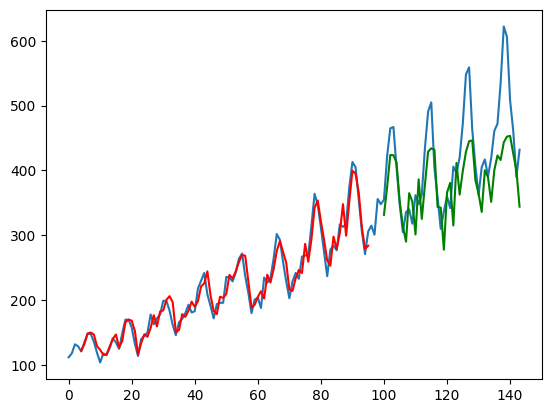

In [ ]:
# Tworzenie DataLoader dla ładowania danych treningowych w paczkach
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

# Określenie liczby epok treningu
n_epochs = 2000
# Pętla treningowa
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Ewaluacja modelu co 100 epok
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

# Rysowanie wykresu
with torch.no_grad():
    # Przewidywania dla danych treningowych
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # Przewidywania dla danych testowych
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# Rysowanie wykresu
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

# Zadanie 1:

- Zaimplementuj SimpleRNN i porownaj z modelem z zajęć
- Zaimplementuj własną wersje LSTM
- Zaimplementuj wlasne GRU
- Porównaj wszystkie trzy modele. Dokonaj co zauważasz? Co jeszcze można poprawić? Czym jest eksplodujacy gradient? Czy zaobserwowales/as to w swoim modelu? Jak mozna temu przeciwdzialac? Zaimplementuj i wykorzystaj wlasna metoda normalizacji.


przykladowa implementacja GRU:

```python

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.gru = nn.GRU(
            input_size=1,
            hidden_size=32,
            num_layers=2,
            batch_first=True,
        )
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 32)
        out, _ = self.gru(x, h0)  
        out = self.fc(out[:, -1, :])
        return out

```
# Zadanie 2:
- Zaimplementuj SimpleRNN i porownaj z modelem z zajęć
- Zaimplementuj własną wersje LSTM
- Zaimplementuj wlasne GRU
dla datasetu akcji Apple z datasetow (https://algotrading101.com/learn/yfinance-guide/) AAPL, GOOG oraz AMZN


Czyli 4 datasety lacznie: do kazdego datasetu SimpleRNN, LSTM, GRU <- czyli lacznie 12 modeli sieci rekruencyjnych . Modele powinny byc omowione wliczajac w to parametry uczenia i warstw predykcja powinna być narysowana.

Finalnie na tych zajeciach powinno powstać 15 modeli sieci rekurencyjnych.

Przykład pracy z datasetami yfinance (przyklad z geeksforgeek)

[*********************100%%**********************]  1 of 1 completed


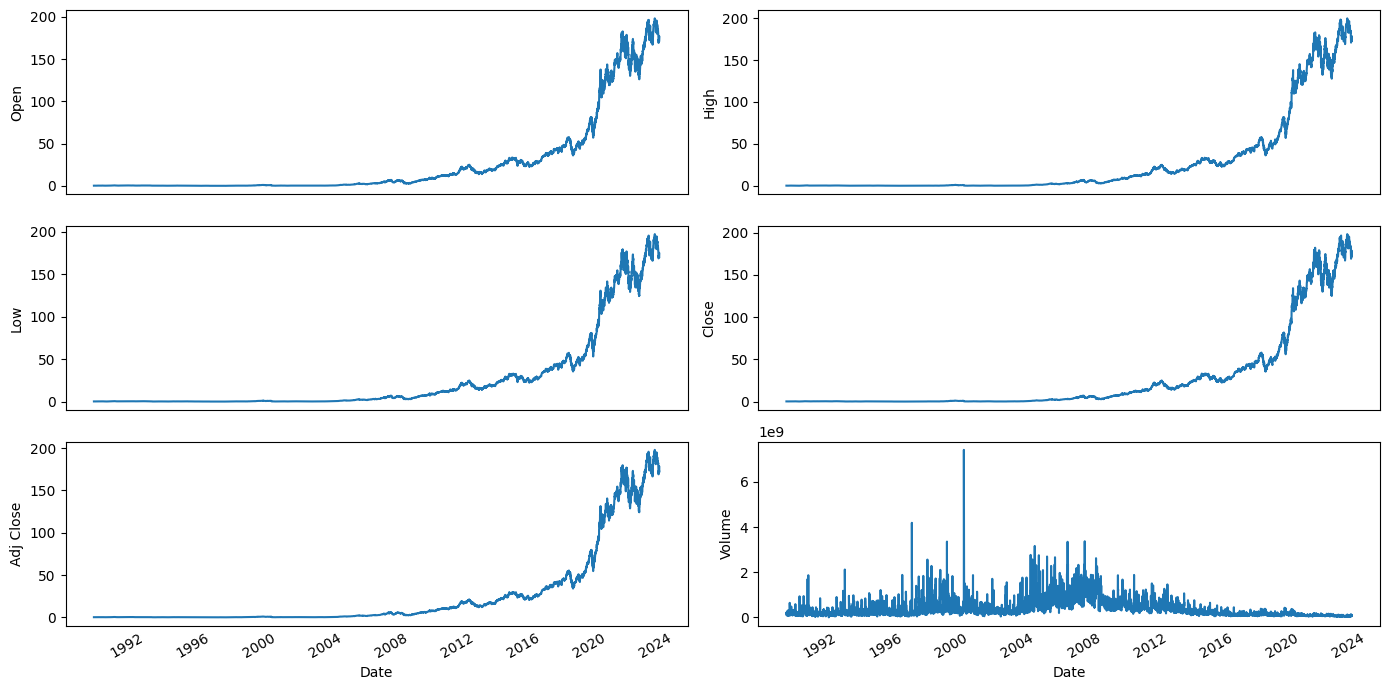

Shape of training data: (6898, 1)
Shape of testing data: (1724, 1)
Shape of scaled training data: (6898, 1)
Shape of scaled testing data: (1724, 1)
Shape of X_train: torch.Size([6848, 50, 1])
Shape of y_train: torch.Size([6848, 50, 1])


In [ ]:
import math
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
# Loading the Apple.Inc Stock Data

import yfinance as yf
from datetime import date, timedelta, datetime
import matplotlib.pyplot as plt # Visualization
import matplotlib.dates as mdates # Formatting dates
import seaborn as sns # Visualization


end_date =  date.today().strftime("%Y-%m-%d") #end date for our data retrieval will be current date
start_date = '1990-01-01' # Beginning date for our historical data retrieval

df = yf.download('AAPL', start=start_date, end=end_date)# Function used to fetch the data

def data_plot(df):
    df_plot = df.copy()

    ncols = 2
    nrows = int(round(df_plot.shape[1] / ncols, 0))

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols,
                           sharex=True, figsize=(14, 7))
    for i, ax in enumerate(fig.axes):
        sns.lineplot(data=df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.tight_layout()
    plt.show()

data_plot(df)

# Splitting the data into training and testing sets
# Allocating 80% of the data for training
training_data_length = math.ceil(len(df) * 0.8)

# Splitting the dataset
training_data = df.iloc[:training_data_length, :1]
testing_data = df.iloc[training_data_length:, :1]

print("Shape of training data:", training_data.shape)
print("Shape of testing data:", testing_data.shape)

# Choosing the 'Open' price values for training
training_data_open = training_data.Open.values.reshape(-1, 1)
# Choosing the 'Open' price values for testing
testing_data_open = testing_data.Open.values.reshape(-1, 1)

# Scaling the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_training_data = scaler.fit_transform(training_data_open)
scaled_testing_data = scaler.transform(testing_data_open)

print("Shape of scaled training data:", scaled_training_data.shape)
print("Shape of scaled testing data:", scaled_testing_data.shape)

# Defining the sequence length
sequence_length = 50  # Number of time steps for backward analysis

# Creating sequences and labels for training data
X_train, y_train = [], []
for i in range(len(scaled_training_data) - sequence_length):
    X_train.append(scaled_training_data[i:i+sequence_length])
    y_train.append(scaled_training_data[i+1:i+sequence_length+1])

# Converting lists to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# Converting data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

# Create sequences and labels for testing data
sequence_length = 30  # Number of time steps to look back
X_test, y_test = [], []
for i in range(len(scaled_testing_data) - sequence_length):
    X_test.append(scaled_testing_data[i:i+sequence_length])
    y_test.append(scaled_testing_data[i+1:i+sequence_length+1])
X_test, y_test = np.array(X_test), np.array(y_test)

# Convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_test.shape, y_test.shape


batch_size = 16
# Create DataLoader for batch training
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for batch training
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
